### Reaction Diffusion equation in JAX

$\begin{aligned}
	&u_t = 0.01u_{xx}+0.01u^2, \quad t\in[0,1],x\in[-1,1], \\
	&u(x,0) = \sin(2\pi x)(1+\cos(2\pi x)).
\end{aligned}$

In [7]:
import jax 
import jax.numpy as jnp
import numpy as np
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import scipy
import matplotlib.pyplot as plt
import pickle
import copy
import time
from tqdm import trange
from typing import Sequence
from functools import partial

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [8]:
M = 10
L = 2.0
layer_sizes = [2*M+1] + [128] * 4 + [1]

class Net(nn.Module):
    layer_sizes: Sequence[int]
    M: int
    L: float

    def setup(self):
        self.W1 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.W2 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.Wz = [nn.Dense(features=size, kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init()) for size in self.layer_sizes[1:]]
        
    def input_encoding(self, x):
        w = 2 * jnp.pi / L
        k = jnp.arange(1, M + 1)
        return jnp.hstack([jnp.ones(x.shape), jnp.cos(k*w*x), jnp.sin(k*w*x)])

    def __call__(self, x):
        X = self.input_encoding(x)
        U = nn.tanh(self.W1(X))
        V = nn.tanh(self.W2(X))

        H = nn.tanh(self.Wz[0](X))
        for linear in self.Wz[1:-1]:
            Z = nn.tanh(linear(H))
            H = jnp.multiply(1 - Z, U) + jnp.multiply(Z, V)
        return self.Wz[-1](H)

net = Net(layer_sizes, M, L)

In [9]:
def mse_fn(true, pred):
    return jnp.mean(jnp.square(true - pred))

def diff(func, argnums):
    return jax.grad(lambda *ar, **kw: jnp.sum(func(*ar, **kw)), argnums=argnums)

@jax.jit
def train_step_u0(state, x_r, x_du0, u_true, du_true):
    def loss_fn(params):
        u_fn = lambda x: state.apply_fn(params, x)
        du_x = diff(u_fn, 0)
        loss_f = 1000*mse_fn(u_true, u_fn(x_r))
        loss_d = mse_fn(du_true, du_x(x_du0))
        
        loss = loss_f + loss_d
        return loss, (loss_f, loss_d)
    grads, (loss_f, loss_d) = jax.grad(loss_fn, argnums=0, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_f, loss_d

@jax.jit
def train_step_rest(state, x, uk, duk_x, duk_xx, N_t):
    def loss_fn(params):
        u_fn = lambda x: state.apply_fn(params, x)
        du_x_fn = diff(u_fn, 0)
        du_xx_fn = diff(du_x_fn, 0)
        u = u_fn(x)
        du_x = du_x_fn(x)
        du_xx = du_xx_fn(x)

        loss = mse_fn((u-uk)/(1/N_t), 0.01*(du_xx+duk_xx)/2 + 0.01*((u+uk)/2)**2)
        return loss, loss
    grads, loss = jax.grad(loss_fn, argnums=0, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [10]:
# u(x, 0)
def U_x0(x):
    return jnp.sin(2*jnp.pi*x)*(1+jnp.cos(2*jnp.pi*x))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2792\2179882208.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(TT, XX, usol, cmap='jet')


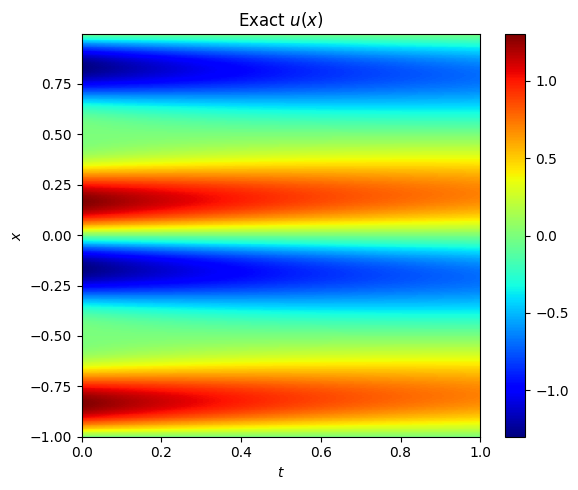

In [11]:
dtdt = 1
N_t = 200*dtdt
N_x = 512
key = jax.random.PRNGKey(1234)
key, skey = jax.random.split(key)
dummy_x = jax.random.uniform(skey, (N_x, 1))
key, skey = jax.random.split(skey)
params = net.init(skey, dummy_x)

# Load the data and grid
data = np.load('data_RD_periodic.npz')
usol = data['usol']
t_star = np.linspace(0, 1, len(usol[0]))
x_star = data['X']
TT, XX = np.meshgrid(t_star, x_star)

# Plot the reference solution
fig = plt.figure(figsize=(6, 5))
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

# Sample points
X_r   = jnp.linspace(-1, 1, N_x).reshape(-1, 1)             # used to train u
X_du0 = jnp.linspace(-1, 1, N_x).reshape(-1, 1)[1:-1:1]     # used to train u_t
X_star= x_star.reshape(-1, 1)                               # used to predict
u0    = U_x0(X_r)                                           # reference solution of u(x, 0) when training
du0_x = diff(U_x0, 0)(X_du0)                                # reference solution of u_t(x, 0) when training
usol0 = usol[:,0].reshape(-1, 1)                            # reference solution of u(x, 0) when predicting

In [12]:
# Train u0
start_time = time.time()
print('Training u0')

#logger
loss_f_log = []
loss_d_log = []
l2_error_log = []
u_pred = []
l2_each_tn_log = []

# optimizer & schedule
lr = 1e-3
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=100,
    decay_rate=0.95
)
optimizer = optax.adam(learning_rate=schedule)

# Train state
state = train_state.TrainState.create(apply_fn=net.apply, params=params, tx=optimizer)

# Load state
# pkl_file = pickle.load(open('Allen_Cahn/states/state{:d}.pkl'.format(0), 'rb'))
# state = flax.serialization.from_state_dict(state, pkl_file)

pbar = trange(1, 10000 + 1, ncols=150)
loss_min = 1e8
for nIter in pbar:
    state, loss_f, loss_d = train_step_u0(state, X_r, X_du0, u0, du0_x)
    loss = loss_f + loss_d

    # Save the best state
    if loss < loss_min:
        state_dict = flax.serialization.to_state_dict(state)
        pickle.dump(state_dict, open('states_seed1234/state{:d}.pkl'.format(0), 'wb'))
        loss_min = loss

    if nIter % 1000 == 0:
        l2_error = jnp.linalg.norm(usol0 - state.apply_fn(state.params, X_star)) / jnp.linalg.norm(usol0)

        loss_f_log.append(loss_f)
        loss_d_log.append(loss_d)
        l2_error_log.append(l2_error)
        pbar.set_postfix_str('loss:{:.2e}, loss_f:{:.2e}, loss_d:{:.2e}, l2_error:{:.2e}, loss_min:{:.2e}'.format(loss, loss_f, loss_d, l2_error, loss_min))

# Load the best state
pkl_file = pickle.load(open('states_seed1234/state{:d}.pkl'.format(0), 'rb'))
state = flax.serialization.from_state_dict(state, pkl_file)
u_pred.append(state.apply_fn(state.params, X_star))
l2_each_tn_log.append(jnp.linalg.norm(usol[:,0:1] - u_pred[-1]) / jnp.linalg.norm(usol[:,0:1]))
elapsed_u0 = time.time() - start_time

Training u0


100%|███████████████████| 10000/10000 [00:40<00:00, 249.43it/s, loss:5.10e-05, loss_f:5.24e-06, loss_d:4.58e-05, l2_error:1.75e-04, loss_min:4.88e-05]


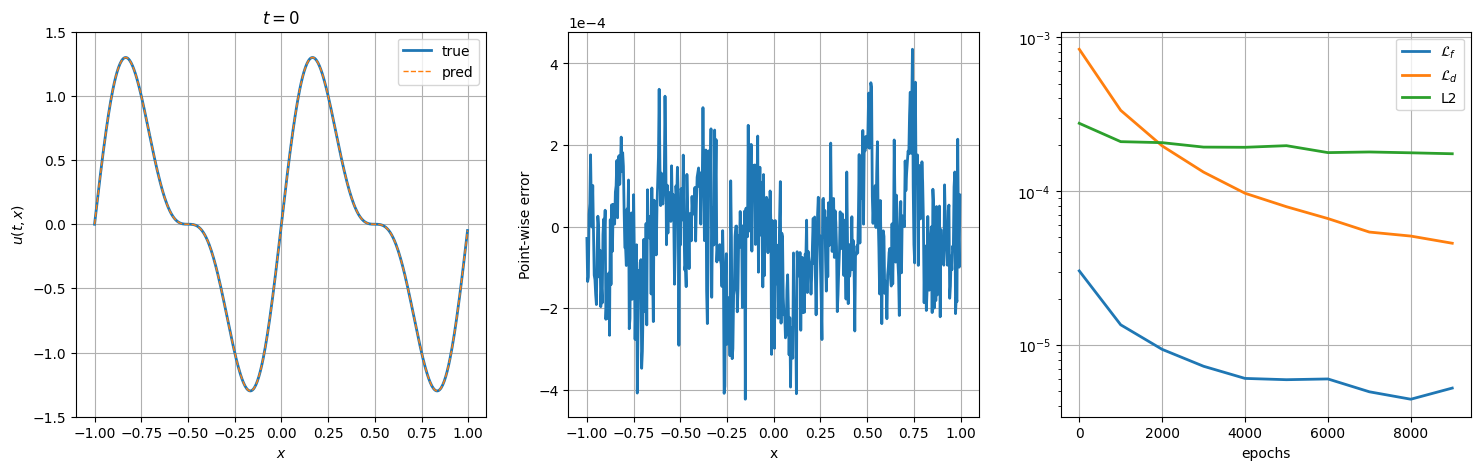

u0 training time: 40 s


In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.set_ylim(-1.5, 1.5)
ax1.plot(X_star, usol[:,0], label='true', linewidth=2)
ax1.plot(X_star, u_pred[0], label='pred', linewidth=1, linestyle='--')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(t, x)$')
ax1.set_title('$t = 0$')
ax1.legend()
ax1.grid(True)

ax2.ticklabel_format(style='sci', scilimits=(0, 0), axis='y')
ax2.plot(X_star, usol0- u_pred[0], linewidth=2)
ax2.set_xlabel('x')
ax2.set_ylabel('Point-wise error')
ax2.grid(True)

plt.yscale('log')
ax3.plot(1000*np.arange(len(loss_f_log)), loss_f_log, label='$\mathcal{L}_{f}$', linewidth=2)
ax3.plot(1000*np.arange(len(loss_d_log)), loss_d_log, label='$\mathcal{L}_{d}$', linewidth=2)
ax3.plot(1000*np.arange(len(l2_error_log)), l2_error_log, label='L2', linewidth=2)
ax3.set_xlabel('epochs')
ax3.legend()
ax3.grid(True)
plt.show()

print('u0 training time: {:.0f} s'.format(elapsed_u0))

In [14]:
# Train u1 u2 u3 ...
start_time_rest = time.time()
print('Training u1 u2 u3 ...')

# optimizer & schedule
lr = 1e-4
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=100,
    decay_rate=0.95
)
optimizer = optax.adam(learning_rate=schedule)

# logger
steps_each_tn_log = []
loss_each_tn_log = []
loss_log = []
loss_min_log = []

pbar = trange(1, N_t + 1, ncols=150)
for t_n in pbar:
    # optimizer = optax.adam(learning_rate=schedule)
    state = train_state.TrainState.create(apply_fn=net.apply, params=state.params, tx=optimizer)

    loss_last = 0
    loss_min = 1e8
    loss_patience = 0
    loss_each_tn_log = []
    
    # Use known Initial Condition when training u1
    if t_n == 1:
        duk_x_fn = diff(U_x0, 0)
        duk_xx_fn = diff(duk_x_fn, 0)
        uk = U_x0(X_r)
        duk_x = duk_x_fn(X_r)
        duk_xx = duk_xx_fn(X_r)
    else:
        uk_fn = lambda x: state.apply_fn(state.params, x)
        duk_x_fn = diff(uk_fn, 0)
        duk_xx_fn = diff(duk_x_fn, 0)
        uk = uk_fn(X_r)
        duk_x = duk_x_fn(X_r)
        duk_xx = duk_xx_fn(X_r)

    for steps in range(1, 10000 + 1):
        state, loss = train_step_rest(state, X_r, uk, duk_x, duk_xx, N_t)
        pbar.set_postfix_str('steps:{:4d}, loss:{:.2e}, min:{:.2e}, l2_last:{:.2e}'.format(steps, loss, loss_min, l2_each_tn_log[-1]))
        loss_each_tn_log.append(loss)
        
        # Save the best state
        if loss < loss_min:
            state_dict = flax.serialization.to_state_dict(state)
            pickle.dump(state_dict, open('states_seed1234/state{:d}.pkl'.format(t_n), 'wb'))
            loss_min = loss
            loss_patience = steps
        
        # Determine whether to proceed to the next time step
        if steps>100 and loss<1e-3 and (0<loss_last-loss<=1e-5 or steps-loss_patience>100):
            break
        loss_last = loss

    # Load the best state & predict
    pkl_file = pickle.load(open('states_seed1234/state{:d}.pkl'.format(t_n), 'rb'))
    state = flax.serialization.from_state_dict(state, pkl_file)
    if t_n % dtdt == 0:
        u_pred.append(state.apply_fn(state.params, X_star)[:,-1:])
        t_index = int(t_n/dtdt)
        usol_tn = usol[:,t_index:t_index+1]
        l2_each_tn_log.append(jnp.linalg.norm(usol_tn - u_pred[-1]) / jnp.linalg.norm(usol_tn))

    # Log
    steps_each_tn_log.append(steps)
    loss_min_log.append(loss_min)
    loss_log.append(loss_each_tn_log)

elapsed_rest = time.time() - start_time_rest

Training u1 u2 u3 ...


100%|████████████████████████████████████████████████████| 200/200 [05:40<00:00,  1.70s/it, steps: 385, loss:9.66e-04, min:3.89e-04, l2_last:1.82e-03]


In [15]:
# save data
path = 'result_seed1234'
pickle.dump(u_pred, open(f'{path}/u_pred.pkl', 'wb'))
pickle.dump(loss_log, open(f'{path}/loss.pkl', 'wb'))
pickle.dump(loss_min_log, open(f'{path}/loss_min.pkl', 'wb'))
pickle.dump(l2_each_tn_log, open(f'{path}/l2_each_tn.pkl', 'wb'))
pickle.dump(steps_each_tn_log, open(f'{path}/steps_each_tn.pkl', 'wb'))

In [16]:
# Load data
# path = 'result_cn'
# u_pred = pickle.load(open(f'{path}/u_pred.pkl', 'rb'))
# loss_log = pickle.load(open(f'{path}/loss.pkl', 'rb'))
# loss_min_log = pickle.load(open(f'{path}/loss_min.pkl', 'rb'))
# l2_each_tn_log = pickle.load(open(f'{path}/l2_each_tn.pkl', 'rb'))
# steps_each_tn_log = pickle.load(open(f'{path}/steps_each_tn.pkl', 'rb'))

In [17]:
# Load states, predict, compute L2 error
# schedule = optax.exponential_decay(init_value=1e-3, transition_steps=100, decay_rate=0.9)
# optimizer = optax.adam(learning_rate=schedule)
# state = train_state.TrainState.create(apply_fn=net.apply, params=params, tx=optimizer)
# l2_each_tn_log = []
# u_pred = []
# for t_n in range(0, N_t+1):
#     if t_n % dtdt == 0:
#         pkl_file = pickle.load(open('states/state{:d}.pkl'.format(t_n), 'rb'))
#         state = flax.serialization.from_state_dict(state, pkl_file)

#         u_pred.append(state.apply_fn(state.params, X_star)[:,-1:])
#         t_index = int(t_n/dtdt)
#         usol_tn = usol[:,t_index:t_index+1]
#         l2_each_tn_log.append(jnp.linalg.norm(usol_tn - u_pred[-1]) / jnp.linalg.norm(usol_tn))
# print(len(l2_each_tn_log))
# print(len(u_pred))

In [18]:
u_pred_copy = copy.deepcopy(u_pred)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2792\4062760281.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(TT, XX, usol, cmap='jet')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2792\4062760281.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(TT, XX, u_pred, cmap='jet')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2792\4062760281.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the sam

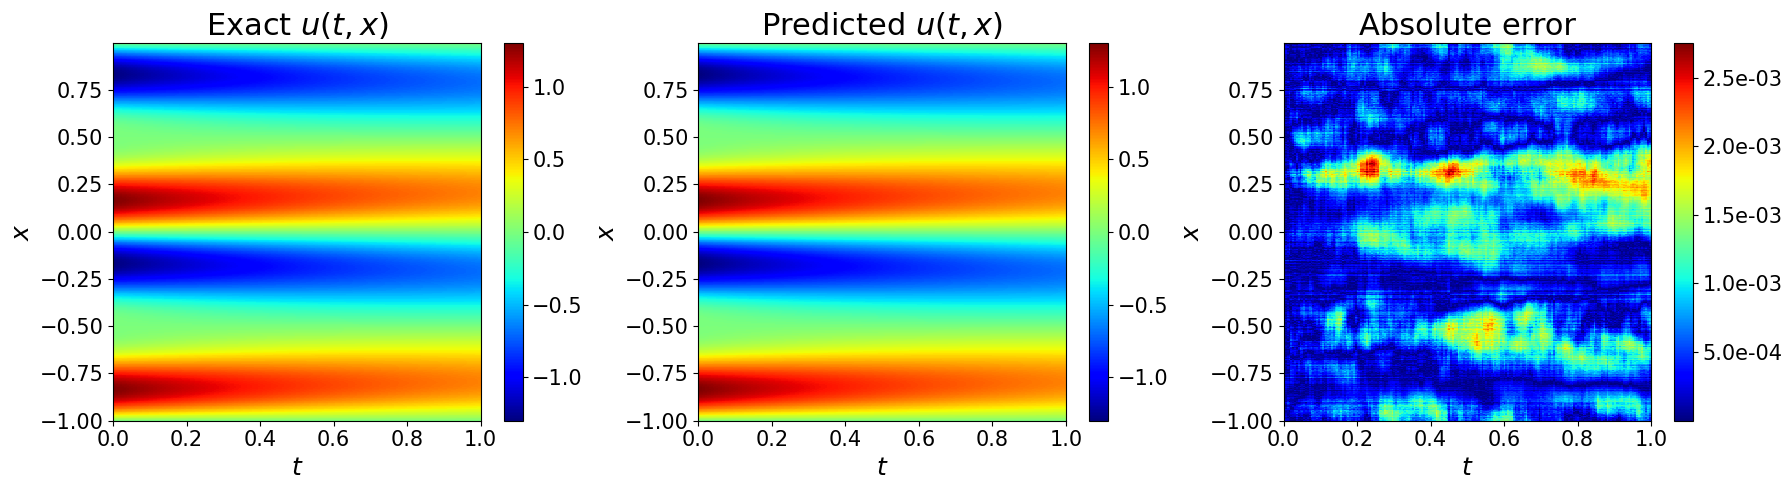

training time after u0: 340 s
total time: 380 s
L2 error = 1.22163e-03


In [19]:
# reshape to the same format & compute L2 error
u_pred = copy.deepcopy(u_pred_copy)
u_pred = np.reshape(u_pred, (len(usol[0]), len(usol))).T
l2_error = np.linalg.norm(usol - u_pred) / np.linalg.norm(usol)

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$x$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title(r'Exact $u(t,x)$', fontsize=22)
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$x$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title(r'Predicted $u(t,x)$', fontsize=22)
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
cbar = plt.colorbar(format='%1.1e')
cbar.ax.tick_params(labelsize=15)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$x$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Absolute error', fontsize=22)
plt.tight_layout()

plt.show()

print('training time after u0: {:.0f} s'.format(elapsed_rest))
print('total time: {:.0f} s'.format(elapsed_u0+elapsed_rest))
print('L2 error = {:.5e}'.format(l2_error))

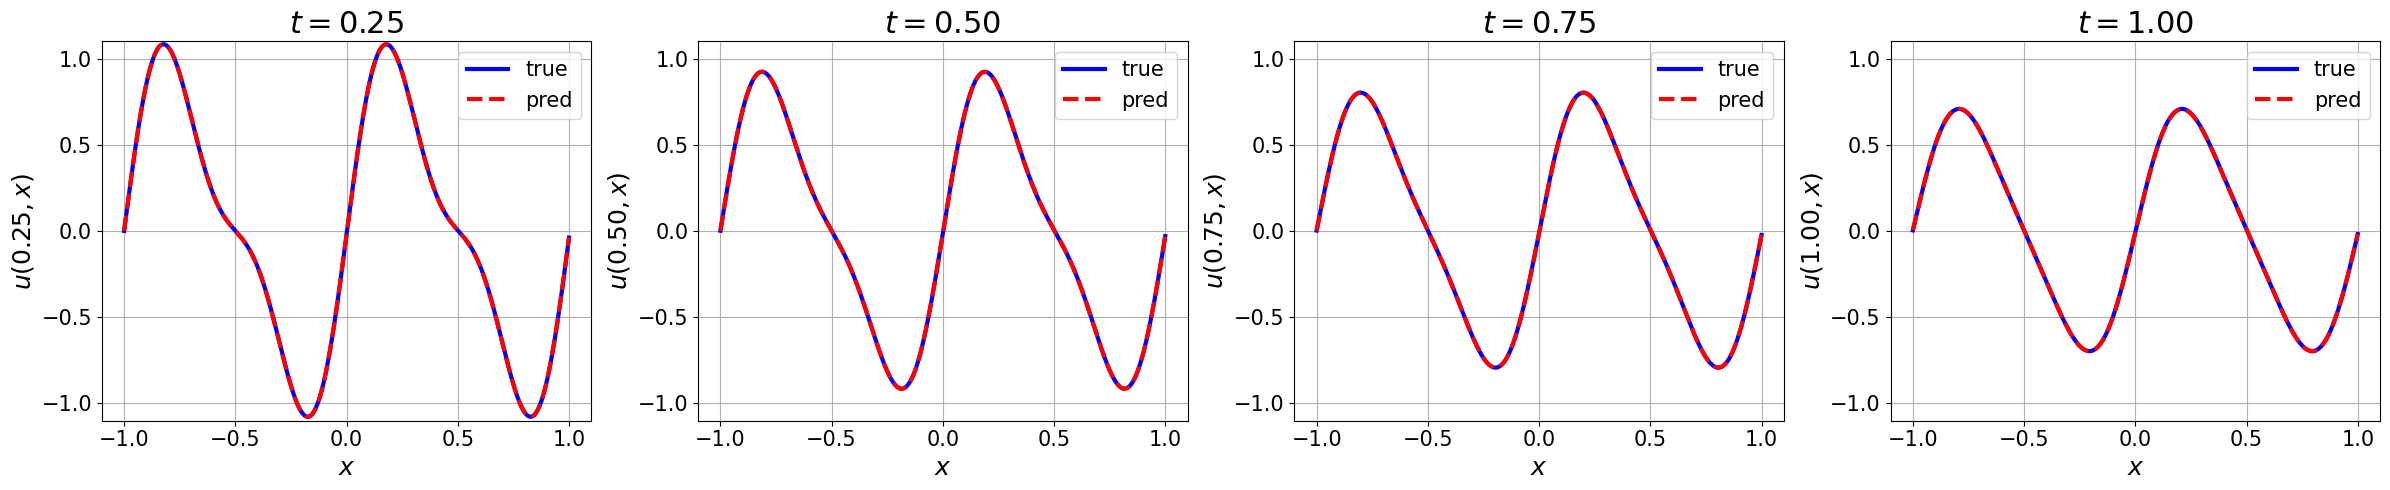

In [20]:
# point wise plot of several time stamps
fig = plt.figure(figsize=(24, 5))
for t in range(1, 5):
    plt.subplot(1, 4, t)
    plt.plot(X_r, usol[:, 50*t:50*t+1], label='true', color='blue', linestyle='-', linewidth=3)
    plt.plot(X_r, u_pred[:, 50*t:50*t+1], label='pred', color='red', linestyle='--', linewidth=3)
    plt.xlabel('$x$', fontsize=18)
    plt.ylabel('$u({:1.2f},x)$'.format(t/4), fontsize=18)
    plt.xticks(ticks=np.arange(-1,1.5,0.5) ,size=15)
    plt.yticks(ticks=np.arange(-1,1.5,0.5) ,size=15)
    plt.ylim(-1.1,1.1)
    plt.title('$t={:1.2f}$'.format(t/4), fontsize=22)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.tight_layout()

plt.show()

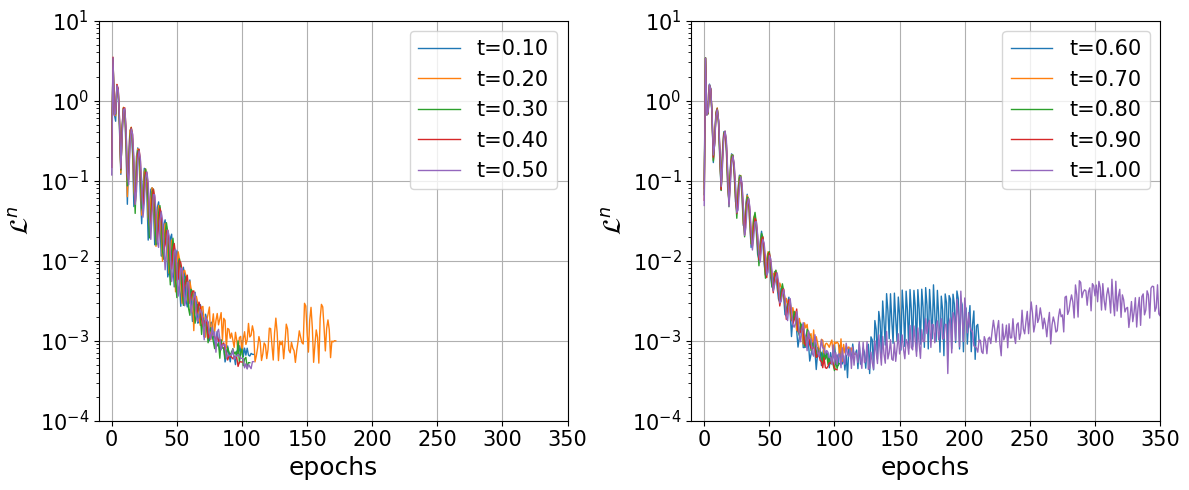

In [21]:
# Loss values of several time stamps
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.xlim(-10, 350)
plt.ylim(1e-4, 1e1)
plt.plot(np.arange(len(loss_log[19])), loss_log[19], label='t=0.10', linewidth=1)
plt.plot(np.arange(len(loss_log[39])), loss_log[39], label='t=0.20', linewidth=1)
plt.plot(np.arange(len(loss_log[59])), loss_log[59], label='t=0.30', linewidth=1)
plt.plot(np.arange(len(loss_log[79])), loss_log[79], label='t=0.40', linewidth=1)
plt.plot(np.arange(len(loss_log[99])), loss_log[99], label='t=0.50', linewidth=1)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('$\mathcal{L}^{n}$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.yscale('log')
plt.xlim(-10, 350)
plt.ylim(1e-4, 1e1)
plt.plot(np.arange(len(loss_log[119])), loss_log[119], label='t=0.60', linewidth=1)
plt.plot(np.arange(len(loss_log[139])), loss_log[139], label='t=0.70', linewidth=1)
plt.plot(np.arange(len(loss_log[159])), loss_log[159], label='t=0.80', linewidth=1)
plt.plot(np.arange(len(loss_log[179])), loss_log[179], label='t=0.90', linewidth=1)
plt.plot(np.arange(len(loss_log[199])), loss_log[199], label='t=1.00', linewidth=1)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('$\mathcal{L}^{n}$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.grid(True)
plt.tight_layout()

plt.show()

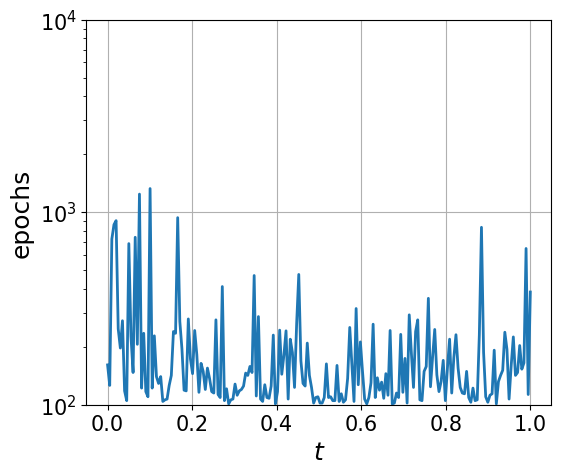

In [22]:
fig = plt.figure(figsize=(6, 5))
plt.subplot(1, 1, 1)
plt.yscale('log')
plt.ylim(100, 10000)
plt.plot(np.linspace(0, 1, len(steps_each_tn_log)), steps_each_tn_log, linewidth=2)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('epochs', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid(True)

plt.show()

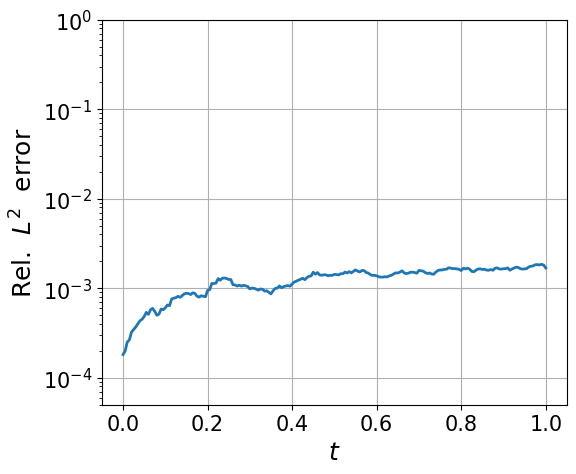

In [23]:
fig = plt.figure(figsize=(6, 5))
plt.subplot(1, 1, 1)
plt.yscale('log')
plt.ylim(5e-5, 1)
plt.plot(np.linspace(0, 1, len(l2_each_tn_log)), l2_each_tn_log, linewidth=2)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('Rel.  $L^2$  error', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid(True)

plt.show()

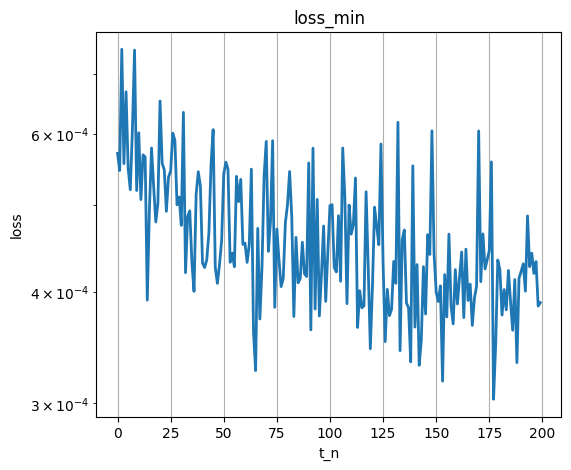

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.arange(len(loss_min_log)), loss_min_log, linewidth=2)
ax.set_xlabel('t_n')
ax.set_ylabel('loss')
ax.set_title('loss_min')
ax.grid(True)
plt.show()